In [1]:
from typing import Callable, Dict, List, Optional

import math
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.observational.handlers import condition
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

pyro.settings.set(module_local_params=True)

match_dropped tensor(1.)
match_dropped Provenance:
frozenset({'u_match_dropped'})
Tensor:
0.0


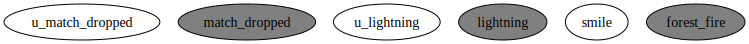

In [2]:
def forest_fire_model():
    u_match_dropped = pyro.sample("u_match_dropped", dist.Bernoulli(0.7))
    match_dropped = pyro.deterministic(
        "match_dropped", u_match_dropped, event_dim=0
    )  # notice uneven probs here

    print("match_dropped", match_dropped.squeeze())

    u_lightning = pyro.sample("u_lightning", dist.Bernoulli(0.4))
    lightning = pyro.deterministic("lightning", u_lightning, event_dim=0)

    # this is a causally irrelevant site
    smile = pyro.sample("smile", dist.Bernoulli(0.5))

    forest_fire = pyro.deterministic(
        "forest_fire", torch.max(match_dropped, lightning) + (0 * smile), event_dim=0
    )

    return {
        "match_dropped": match_dropped,
        "lightning": lightning,
        "forest_fire": forest_fire,
    }

with ExtractSupports() as extract_supports:
    forest_fire_model()
    forest_fire_supports = {k: constraints.boolean for k in extract_supports.supports}

pyro.render_model(forest_fire_model)

In [3]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc, log_weights

    return _wrapped_model

In [4]:
query = SearchForExplanation(
    supports=forest_fire_supports,
    antecedents={"match_dropped": torch.tensor(1.0), "lightning": torch.tensor(1.0)},
    consequents={"forest_fire": torch.tensor(1.0)},
    witnesses={}, # potential context elements, we leave them empty for now
    alternatives={"match_dropped": torch.tensor(0.0), "lightning": torch.tensor(0.0)},
    consequent_scale=1e-5,
    antecedent_bias=0.5
)(forest_fire_model)

In [5]:
logp, trace, mwc, log_weights = importance_infer(num_samples=10)(query)()

match_dropped tensor([[0., 0., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 0.]])
match_dropped tensor([[0., 0., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 0.],
        [0., 0., 0.]])


In [36]:
with mwc:
    print(indices_of(trace.nodes["match_dropped"]["value"]))

IndexSet({})


In [1]:
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pytest
import torch

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.counterfactual.ops import split
from chirho.explainable.handlers import random_intervention, sufficiency_intervention
from chirho.explainable.handlers.components import (  # consequent_eq_neq,
    ExtractSupports,
    consequent_eq,
    consequent_eq_neq,
    consequent_neq,
    undo_split,
)
from chirho.explainable.internals import uniform_proposal
from chirho.explainable.ops import preempt
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.interventional.ops import intervene
from chirho.observational.handlers.condition import Factors

In [23]:
import pyro.distributions.constraints as constraints
import torch
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.counterfactual.ops import split
from chirho.explainable.handlers.components import undo_split
from chirho.indexed.ops import IndexSet, gather, indices_of

with MultiWorldCounterfactual():
    x_obs = torch.ones(10)
    x_cf_1 = 2 * x_obs
    x_cf_2 = 3 * x_cf_1
    x_split = split(x_obs, (x_cf_1,), name="split1", event_dim=1)
    x_split = split(x_split, (x_cf_2, x_cf_1), name="split2", event_dim=1)

    print(x_split)

    undo_split2 = undo_split(
        support=constraints.independent(constraints.real, 1), antecedents=["split2"]
    )
    x_undone = undo_split2(x_split)

    print(indices_of(x_split, event_dim=1))
    print(indices_of(x_undone, event_dim=1))

    print(gather(x_split, IndexSet(split2={0}), event_dim=1))
    print(x_undone)

    assert indices_of(x_split, event_dim=1) == indices_of(x_undone, event_dim=1)
    assert torch.all(gather(x_split, IndexSet(split2={0}), event_dim=1) == x_undone)

tensor([[[[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]],





        [[[[[[6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]]]]],




         [[[[[6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]]]]]],





        [[[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]]])
IndexSet({'split1': {0, 1}, 'split2': {0, 1, 2}})
IndexSet({'split1': {0, 1}, 'split2': {0, 1, 2}})
tensor([[[[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]]])
tensor([[[[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]],





        [[[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]],





        [[[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]]],




         [[[[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]]]]]])


In [27]:
index_keys = []
antecedents = {"split1": {0, 1, 2}, "split2": {1, 2}, "split3": {2, 3}}
for a, v in antecedents.items():
    if index_keys == []:
        for value in v:
            index_keys.append({a: {value}})
    else:
        temp_index_keys = []
        for i in index_keys:
            for value in v:
                print(i)
                t = dict(i)
                t[a] = {value}
                temp_index_keys.append(t)
        index_keys = temp_index_keys

print(index_keys)




{'split1': {0}}
{'split1': {0}}
{'split1': {1}}
{'split1': {1}}
{'split1': {2}}
{'split1': {2}}
{'split1': {0}, 'split2': {1}}
{'split1': {0}, 'split2': {1}}
{'split1': {0}, 'split2': {2}}
{'split1': {0}, 'split2': {2}}
{'split1': {1}, 'split2': {1}}
{'split1': {1}, 'split2': {1}}
{'split1': {1}, 'split2': {2}}
{'split1': {1}, 'split2': {2}}
{'split1': {2}, 'split2': {1}}
{'split1': {2}, 'split2': {1}}
{'split1': {2}, 'split2': {2}}
{'split1': {2}, 'split2': {2}}
[{'split1': {0}, 'split2': {1}, 'split3': {2}}, {'split1': {0}, 'split2': {1}, 'split3': {3}}, {'split1': {0}, 'split2': {2}, 'split3': {2}}, {'split1': {0}, 'split2': {2}, 'split3': {3}}, {'split1': {1}, 'split2': {1}, 'split3': {2}}, {'split1': {1}, 'split2': {1}, 'split3': {3}}, {'split1': {1}, 'split2': {2}, 'split3': {2}}, {'split1': {1}, 'split2': {2}, 'split3': {3}}, {'split1': {2}, 'split2': {1}, 'split3': {2}}, {'split1': {2}, 'split2': {1}, 'split3': {3}}, {'split1': {2}, 'split2': {2}, 'split3': {2}}, {'split1': {2}

In [28]:

antecedents_ = {
    a
    for a in antecedents
    if a in indices_of(value, event_dim=0)
}

factual_value = gather(
    value,
    IndexSet(**{antecedent: {0} for antecedent in antecedents_}),
    event_dim=support.event_dim,
)

# TODO exponential in len(antecedents) - add an indexed.ops.expand to do this cheaply



scatter_n(
    {
        IndexSet(
            **{antecedent: {ind} for antecedent, ind in zip(antecedents_, inds)}
        ): factual_value
        for inds in itertools.product(*[[0, 1]] * len(antecedents_))
    },
    event_dim=support.event_dim,
)

SyntaxError: invalid syntax (448003560.py, line 4)

In [30]:
with MultiWorldCounterfactual():
    for a in indices_of(value, event_dim=0):
        print(a)


In [15]:
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pytest
import torch

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.counterfactual.ops import split
from chirho.explainable.handlers import random_intervention, sufficiency_intervention
from chirho.explainable.handlers.components import (  # consequent_eq_neq,
    ExtractSupports,
    consequent_eq,
    consequent_eq_neq,
    consequent_neq,
    undo_split,
)
from chirho.explainable.internals import uniform_proposal
from chirho.explainable.ops import preempt
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.interventional.ops import intervene
from chirho.observational.handlers.condition import Factors

SUPPORT_CASES = [
    pyro.distributions.constraints.real,
    pyro.distributions.constraints.boolean,
    pyro.distributions.constraints.positive,
    pyro.distributions.constraints.interval(0, 10),
    pyro.distributions.constraints.interval(-5, 5),
    pyro.distributions.constraints.integer_interval(0, 2),
    pyro.distributions.constraints.integer_interval(0, 100),
]

In [19]:
import pyro
import pyro.distributions as dist

def model():
    x = pyro.sample("x", dist.Delta(torch.tensor(1.0)))

    x_split = pyro.deterministic(
        "x_split",
        split(x, (torch.tensor(0.5),), name="x_split", event_dim=0),
        event_dim=0,
    )

    x_undone = pyro.deterministic(
        "x_undone",
        undo_split(support=constraints.real, antecedents=["x_split"])(x_split),
        event_dim=0,
    )

    x_case = torch.tensor(1)
    x_preempted = pyro.deterministic(
        "x_preempted",
        preempt(
            x_undone, (torch.tensor(5.0),), x_case, name="x_preempted", event_dim=0
        ),
        event_dim=0,
    )

    x_undone_2 = pyro.deterministic(
        "x_undone_2",
        undo_split(support=constraints.real, antecedents=["x"])(x_preempted),
        event_dim=0,
    )

    x_split2 = pyro.deterministic(
        "x_split2",
        split(x_undone_2, (torch.tensor(2.0),), name="x_split2", event_dim=0),
        event_dim=0,
    )

    x_undone_3 = pyro.deterministic(
        "x_undone_3",
        undo_split(support=constraints.real, antecedents=["x_split", "x_split2"])(
            x_split2
        ),
        event_dim=0,
    )

    return x_undone_3

with MultiWorldCounterfactual() as mwc:
    with pyro.poutine.trace() as tr:
        model()

nd = tr.trace.nodes

with mwc:
    x_split_2 = nd["x_split2"]["value"]
    x_00 = gather(
        x_split_2, IndexSet(x_split={0}, x_split2={0}), event_dim=0
    )  # 5.0
    x_10 = gather(
        x_split_2, IndexSet(x_split={1}, x_split2={0}), event_dim=0
    )  # 5.0
    x_01 = gather(
        x_split_2, IndexSet(x_split={0}, x_split2={1}), event_dim=0
    )  # 2.0
    x_11 = gather(
        x_split_2, IndexSet(x_split={1}, x_split2={1}), event_dim=0
    )  # 2.0

    assert (
        nd["x_split"]["value"][0].item() == 1.0
        and nd["x_split"]["value"][1].item() == 0.5
    )

    assert (
        nd["x_undone"]["value"][0].item() == 1.0
        and nd["x_undone"]["value"][1].item() == 1.0
    )

    assert (
        nd["x_preempted"]["value"][0].item() == 5.0
        and nd["x_preempted"]["value"][1].item() == 5.0
    )

    assert (
        nd["x_undone_2"]["value"][0].item() == 5.0
        and nd["x_undone_2"]["value"][1].item() == 5.0
    )

    assert torch.all(nd["x_undone_3"]["value"] == 5.0)

    assert (x_00, x_10, x_01, x_11) == (5.0, 5.0, 2.0, 2.0)